# Synthetic Data Tutorial

This notebook shows how to process MTH5 data from a synthetic dataset.

It also shows how to modify processing so that Fourier coefficients are saved in the mth5.  These FCs can be used to perform TF estimation using different regression settings.  The same FCs will be used for feature extraction in future (This section is a work in Progress). 

## Contents:

1. [Process Synthetic Data with Aurora](#Process-Synthetic-Data-with-Aurora)
2. [Fourier coefficient storage in MTH5](#Fourier-coefficient-storage-in-MTH5)

## Process Synthetic Data with Aurora

Here is a minimal example of running aurora processing on an mth5 populated with synthetic time series.


Steps:
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

### Here are the modules we will need to import 

In [1]:
import pathlib
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.data.make_mth5_from_asc import create_test12rr_h5
from mth5.data.paths import SyntheticTestPaths
from mtpy.processing import RunSummary, KernelDataset

warnings.filterwarnings('ignore')

/home/kkappler/software/irismt/mtpy-v2/mtpy/modeling/simpeg/recipes/inversion_2d.py:39: UserWarning: Pardiso not installed see https://github.com/simpeg/pydiso/blob/main/README.md.
  warnings.warn(


### Define target folder and mth5 path

By default, the synthetic mth5 file is used for testing in `aurora/tests/synthetic/` and probably already exists on your system if you have run the tests. In the code below, we check if the file exists already, and if not we make it.

**NOTE:** If using a read-only HPC installation, you may not be able to write to the directory where aurora is installed.  In that case, defining your target path as somewhere you have write permission.  In that case, uncommment the READ ONLY INSTALLATION block below.

In [2]:
synthetic_test_paths = SyntheticTestPaths()
target_folder = synthetic_test_paths.mth5_path

## READ ONLY INSTALLATION
# home = pathlib.Path.home()
# target_folder = home.joinpath("aurora_test_folder")
# target_folder.mkdir(parents=True, exist_ok=True)

mth5_path = target_folder.joinpath("test12rr.h5")

If the mth5 doesn't already exist, or you want to re-make it, call `create_test12rr_h5()`

In [3]:
# Uncomment this to start with a fresh mth5 file

# mth5_path.unlink()

In [4]:
if not mth5_path.exists():
    create_test12rr_h5(target_folder=target_folder)   

### Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want.
Run summary takes a list of mth5 paths as input argument.

In [5]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

24:11:08T16:55:58 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Define a Kernel Dataset


In [6]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

24:11:08T16:56:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:11:08T16:56:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:11:08T16:56:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:11:08T16:56:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:11:08T16:56:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config will get its information about the specific stations to process via the kernel dataset.

**NOTE:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [7]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()

24:11:08T16:56:03 | INFO | line:108 |aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


### Take a look at the processing configuration

In [8]:
config

{
    "processing": {
        "band_setup_file": "/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
 

# Modify for non-conventional TF

In [9]:
for decimation in config.decimations:
    decimation.input_channels = ["hx", "hy", "hz"]
    decimation.output_channels = ["ex", "ey",]
    decimation.reference_channels = ["hx", "hy", "hz"]


### Call process_mth5

24:11:08T16:57:28 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:11:08T16:57:28 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   39999.0      True  

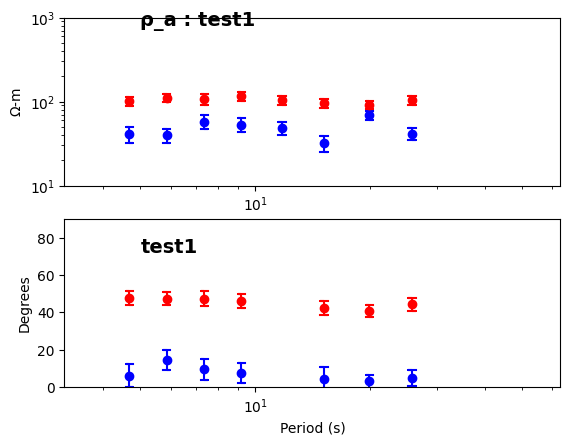

24:11:08T16:57:31 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1
24:11:08T16:57:31 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
24:11:08T16:57:32 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:32 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:32 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 102.915872s  (0.009717Hz)
24:11:08T16:57:32 | ERROR | line:208 |aurora.transfer_function.weights.edf_weights | effective_degrees_of_freedom_weights | edfwts only works for 2 input channels, not 3
24:11:08T16:57:32 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estima

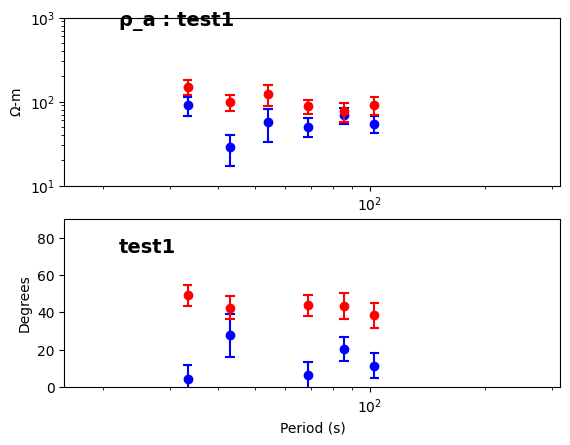

24:11:08T16:57:33 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2
24:11:08T16:57:33 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
24:11:08T16:57:33 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:33 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:33 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 411.663489s  (0.002429Hz)
24:11:08T16:57:33 | ERROR | line:208 |aurora.transfer_function.weights.edf_weights | effective_degrees_of_freedom_weights | edfwts only works for 2 input channels, not 3
24:11:08T16:57:33 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estima

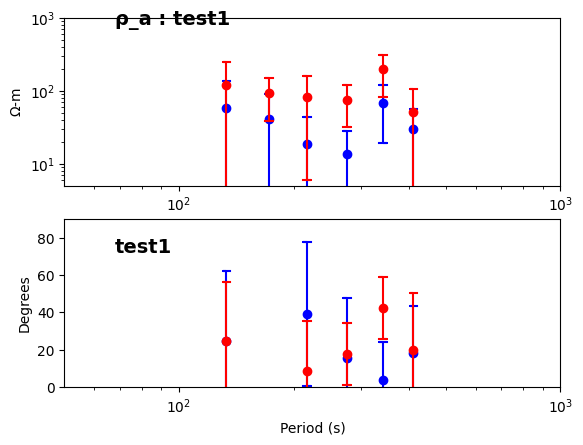

24:11:08T16:57:34 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3
24:11:08T16:57:34 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
24:11:08T16:57:34 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:34 | INFO | line:354 |aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
24:11:08T16:57:34 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 1514.701336s  (0.000660Hz)
24:11:08T16:57:34 | ERROR | line:208 |aurora.transfer_function.weights.edf_weights | effective_degrees_of_freedom_weights | edfwts only works for 2 input channels, not 3
24:11:08T16:57:34 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estim

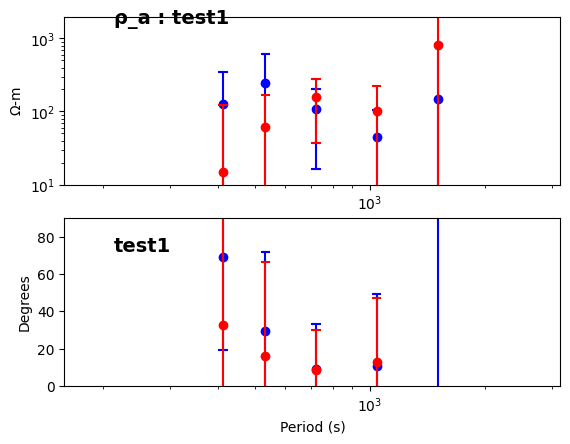

24:11:08T16:57:35 | ERROR | line:753 |mt_metadata.transfer_functions.core | _validate_input_dataarray | Input dimensions must be ['hx', 'hy'] not ['hx', 'hy', 'hz']
24:11:08T16:57:35 | ERROR | line:564 |aurora.pipelines.process_mth5 | process_mth5_legacy | TF collection could not export to mt_metadata TransferFunction
Failed with exception Input dimensions must be ['hx', 'hy'] not ['hx', 'hy', 'hz']
Perhaps an unconventional mixture of input/output channels was used
Input channels were ['hx', 'hy', 'hz']
Output channels were ['ex', 'ey']
No z-file will be written in this case
Will return a legacy TransferFunctionCollection object, not mt_metadata object.
24:11:08T16:57:35 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5
24:11:08T16:57:35 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


In [10]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [11]:
tf_cls

In [12]:
tf_cls.tf_dict

{0: <aurora.transfer_function.TTFZ.TTFZ at 0x73d4acb7aa60>,
 1: <aurora.transfer_function.TTFZ.TTFZ at 0x73d4519224c0>,
 2: <aurora.transfer_function.TTFZ.TTFZ at 0x73d43790ee50>,
 3: <aurora.transfer_function.TTFZ.TTFZ at 0x73d437904430>}

In [14]:
tf_cls.tf_dict[0].transfer_function

<xarray.DataArray (output_channel: 2, input_channel: 3, period: 8)> Size: 768B
array([[[-6.50047813e+00+0.67270965j, -5.05831262e+00+0.86436402j,
         -4.79029167e+00-0.40900864j, -4.51776869e+00-0.1331047j ,
         -4.76448356e+00+0.06596776j, -3.82525248e+00+0.83356921j,
         -3.33351631e+00-0.5643264j , -2.92534247e+00+0.31513604j],
        [ 6.58607323e+00+0.69154152j,  5.62306254e+00+1.45145861j,
          6.16901740e+00+1.03519891j,  5.31793610e+00+0.70813855j,
          4.54053410e+00-0.16510518j,  3.25350955e+00+0.24720464j,
          4.13876508e+00+0.23045734j,  2.83092174e+00+0.24689349j],
        [ 2.61468389e+01-2.57329419j,  2.00738930e+01-3.46264119j,
          1.91822424e+01+1.5874806j ,  1.78901029e+01+0.51592058j,
          1.91509471e+01-0.18933851j,  1.52322064e+01-3.36528685j,
          1.33724730e+01+2.23514778j,  1.15174305e+01-1.19961239j]],

       [[-7.00003806e+00-7.68739979j, -6.59320999e+00-7.18564681j,
         -5.78740590e+00-6.2762784j , -5.51149166e+00-5.70864411j,
         -4.85970841e+00-4.51874327j, -4.14921890e+00-3.80279919j,
         -3.63365775e+00-3.12042204j, -3.21045916e+00-3.13042092j],
        [ 4.37665053e-01+0.25921229j,  7.13706038e-01-0.12999767j,
          4.80202109e-01+0.02543948j,  5.51920596e-01-0.30952086j,
          3.29240322e-03-0.25366174j, -2.43418443e-01-0.02439256j,
         -4.19234687e-01-0.10973541j,  1.17437016e-01-0.07718187j],
        [-1.06799963e+00+1.64672456j,  4.52489364e-01+2.97932829j,
         -1.19649982e-01+1.8994398j ,  1.17208711e+00+2.14417171j,
          1.14034910e+00-0.04107789j,  5.05777754e-02-0.85829586j,
          3.47451928e-01-1.58980816j,  2.40956601e-01+0.19009813j]]])
Coordinates:
  * period          (period) float64 64B 4.682 5.856 7.363 ... 15.16 19.93 25.73
  * output_channel  (output_channel) <U2 16B 'ex' 'ey'
  * input_channel   (input_channel) <U2 24B 'hx' 'hy' 'hz'

In [15]:
tf_cls.tf_dict[1].transfer_function

<xarray.DataArray (output_channel: 2, input_channel: 3, period: 6)> Size: 576B
array([[[-2.38480857-1.01472239j, -1.57538712+0.77230618j,
         -2.35750955-0.14370738j, -1.71344768-0.04888822j,
         -1.01773846-0.25038317j, -1.24578516-0.04616615j],
        [ 3.67746694+0.29695182j,  1.61964884+0.85583868j,
          2.2933426 -0.19575574j,  1.89645413+0.2119012j ,
          1.88423303+0.69716899j,  1.59828432+0.32116744j],
        [ 9.60811479+3.87282861j,  6.27814411-3.111502j  ,
          9.30816779+0.80342085j,  6.84281266+0.0462613j ,
          4.04628365+0.78770492j,  4.76941096+0.26523587j]],

       [[-3.10971873-3.59934745j, -2.48840166-2.28189879j,
         -2.34587643-2.40562029j, -1.81763105-1.75022216j,
         -1.53054872-1.45563145j, -1.64243294-1.30616842j],
        [ 0.80275312-0.39206741j, -0.09654607-0.08445139j,
          0.25522267-0.20834455j, -0.19373402+0.12148435j,
         -0.2398339 +0.22376425j, -0.20408235-0.14786198j],
        [ 1.59328274+3.34370256j,  0.43650178-0.37175267j,
          0.82138048+1.16094613j, -0.30163279-0.86991321j,
         -0.87503057-0.96168875j,  0.37123256-1.01070181j]]])
Coordinates:
  * period          (period) float64 48B 33.31 43.0 54.2 68.88 85.63 102.9
  * output_channel  (output_channel) <U2 16B 'ex' 'ey'
  * input_channel   (input_channel) <U2 24B 'hx' 'hy' 'hz'

In [16]:
tf_cls.tf_dict[2].transfer_function

<xarray.DataArray (output_channel: 2, input_channel: 3, period: 6)> Size: 576B
array([[[-0.72570444+0.04085121j, -2.07668645+0.65701146j,
         -0.64190942+0.51095421j, -0.7893782 +0.5314432j ,
         -0.80239452-0.07171476j, -0.59149454+0.20007772j],
        [ 1.34183128+0.62274773j,  0.65833959-0.85867768j,
          0.50951564+0.41673589j,  0.47370342+0.13284787j,
          0.99756723+0.06556841j,  0.57242061+0.18909031j],
        [ 2.9426646 -0.19740719j,  8.2540808 -2.39223804j,
          2.63303264-2.18755509j,  3.18540309-2.01958181j,
          3.02505211+0.42231067j,  2.45991419-0.84118j   ]],

       [[-1.91777816-0.89092061j, -1.39660968-0.88550633j,
         -1.36650956-0.21220529j, -1.10860941-0.35765165j,
         -1.24956451-1.1417356j , -0.73688191-0.2698234j ],
        [-0.51826482-0.59719204j, -0.29799801-0.17472597j,
         -0.82548225-0.31052916j, -0.62539129-0.15079481j,
          0.30090774-0.42439856j, -0.43650151+0.07175227j],
        [ 2.31380479-1.97509874j,  0.85811432-1.21404219j,
          1.37295396-3.28965443j,  0.50384954-2.41877854j,
          1.58550618+1.04183855j, -0.14763784-2.06225911j]]])
Coordinates:
  * period          (period) float64 48B 133.2 172.0 216.8 275.5 342.5 411.7
  * output_channel  (output_channel) <U2 16B 'ex' 'ey'
  * input_channel   (input_channel) <U2 24B 'hx' 'hy' 'hz'

In [17]:
tf_cls.tf_dict[3].transfer_function

<xarray.DataArray (output_channel: 2, input_channel: 3, period: 5)> Size: 480B
array([[[ 0.37064244+0.3223102j ,  0.06679967-0.66018674j,
         -0.4940566 -0.31909628j, -0.45354767+0.05103162j,
         -1.1545326 +0.23502009j],
        [ 0.44002023+1.16143672j,  1.32748295+0.74412977j,
          0.85396317+0.13488647j,  0.45363057+0.08690251j,
          0.15551897-0.68326806j],
        [-1.35747008-1.21798684j, -0.26908936+2.79339378j,
          1.88221377+1.19156859j,  1.76292444-0.1475252j ,
          4.60088257-1.1026431j ]],

       [[ 0.35517368+0.2261841j , -0.72885597-0.2074237j ,
         -1.0322705 -0.15378022j, -0.68114461-0.15353018j,
         -1.63220449+0.21952566j],
        [-1.05572637+1.22781336j, -0.50737613-0.04816998j,
         -0.40497921-0.465143j  , -0.34816637-0.13037868j,
         -0.62336517-1.13930797j],
        [-4.68353371-4.03239285j,  0.14205748-2.03419946j,
          1.72252174-1.62850785j,  0.679333  -1.39094575j,
          4.72429292-2.75348913j]]])
Coordinates:
  * period          (period) float64 40B 412.8 533.0 723.4 1.042e+03 1.515e+03
  * output_channel  (output_channel) <U2 16B 'ex' 'ey'
  * input_channel   (input_channel) <U2 24B 'hx' 'hy' 'hz'

### Export TF to a file 

<div class="alert alert-block alert-info"> <b>NOTE</b> This wont work becasue TF collection can't write a z-file </div>


In [19]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write(fn=xml_file_base, file_type="emtfxml")


AttributeError: 'TransferFunctionCollection' object has no attribute 'write'